In [124]:
import os

import pandas as pd
import numpy as np

# viz stuff
%matplotlib inline
from IPython.display import display, clear_output, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
#import plotly.figure_factory as ff

# Reading in the file

First up, I'm reading in just the training csv file. This is `629M` in size which is pretty big so first up I want to optimize it as much as possible using [some of these tips](https://www.dataquest.io/blog/pandas-big-data/).

In [3]:
path = "../data/pubg/"
os.listdir(path)

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']

In [4]:
df_train = pd.read_csv(path + "train_V2.csv")
print(df_train.shape)
df_train.head()

(4446966, 29)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [67]:
df_train.isna().sum()

NameError: name 'df_train' is not defined

In [36]:
df_train.info(memory_usage='deep')

NameError: name 'df_train' is not defined

So we have a dataframe using two gigabytes of memory! Which is more than my laptop running jupyter inside a VM can handle well. So first up, pandas has cast most of the columns into int64 or object types, which takes up more memory than we actually need to store the kind of data we have.

In [8]:
for dtype in ['float','int','object']:
    selected_dtype = df_train.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 29.08 MB
Average memory usage for int columns: 32.23 MB
Average memory usage for object columns: 235.18 MB


In [11]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [17]:
df = reduce_mem_usage(df_train)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory usage: 1.3 GB


So now we're down to 1.3gb from 2gb. The four object cols are still taking up ~235MB each so taking a look at those, the matchType can be converted to a category type:

In [18]:
df_obj = df.select_dtypes(include=['object']).copy()
df_obj.describe()

,Id,groupId,matchId,matchType
count,4446966,4446966,4446966,4446966
unique,4446966,2026745,47965,16
top,6c76be1f50f168,14d6b54cdec6bc,405b6810a8a869,squad-fpp
freq,1,74,100,1756186


In [19]:
df["matchType"] = df["matchType"].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          category
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: category(1), float16(6), int16(5), int8(14), object(3)
memory usage: 1.0 GB


Great, we've gone from 2gb memory use to 1gb. So moving on..

# EDA

Using only the first 5000 rows to speed things up while I figure out what plots are useful

In [111]:
df = df.iloc[:8000]
df.shape

(5000, 29)

In [112]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

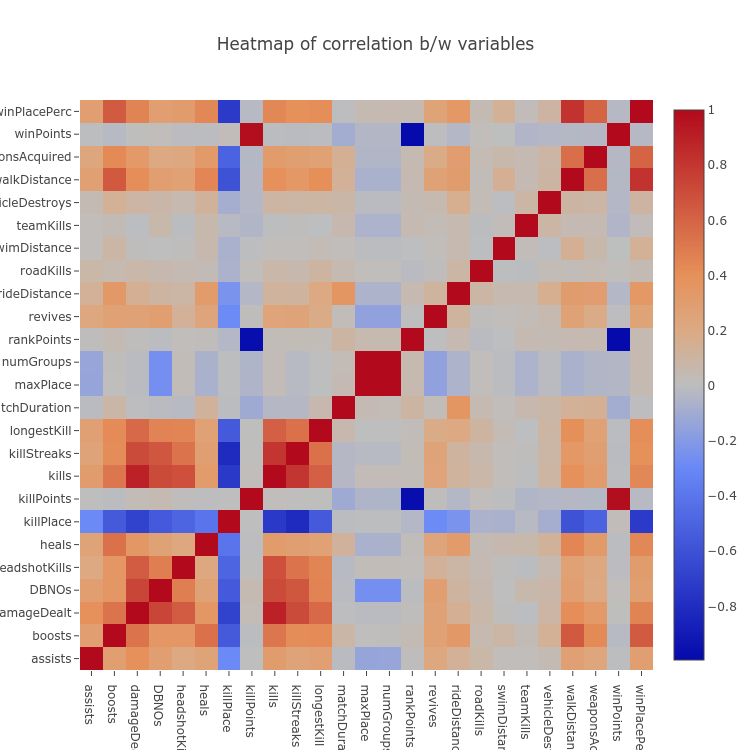

In [120]:
temp = df.corr()
data = [go.Heatmap(x=temp.index, y=temp.columns, z=temp.values)]

layout = go.Layout(title="Heatmap of correlation b/w variables", 
                  width=750, height=750)
fig = go.Figure(data, layout)
py.iplot(fig)

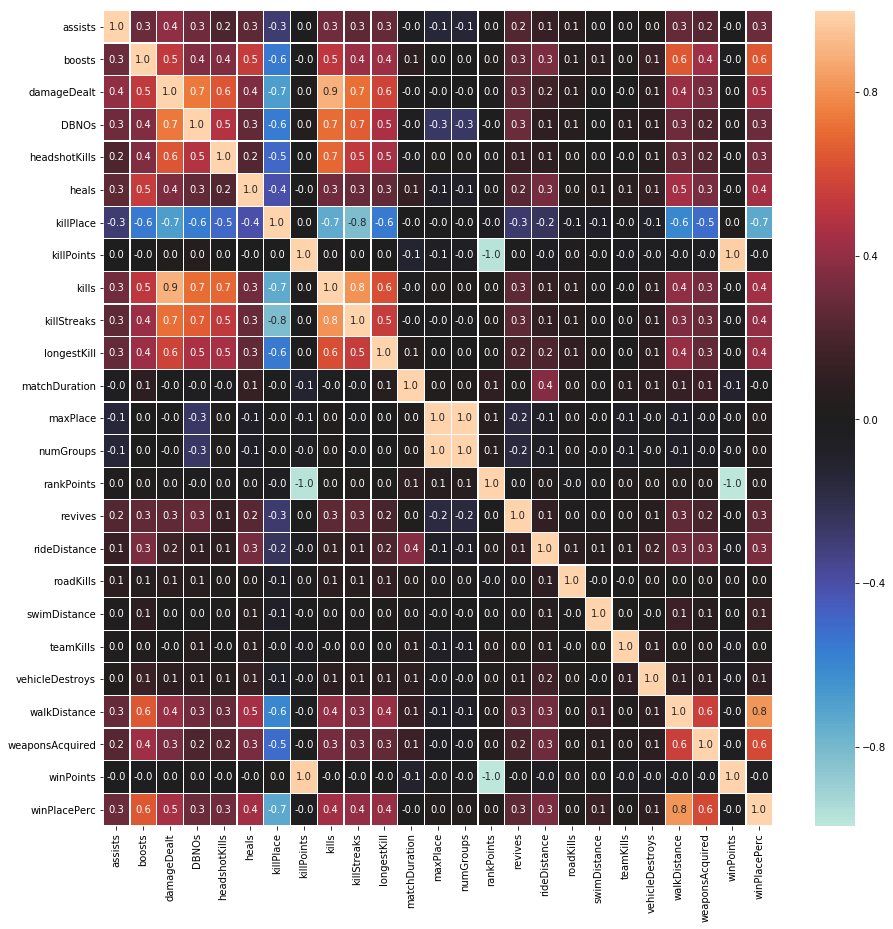

In [91]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, linewidths=0.3, fmt='.1f', ax=ax, center=0);

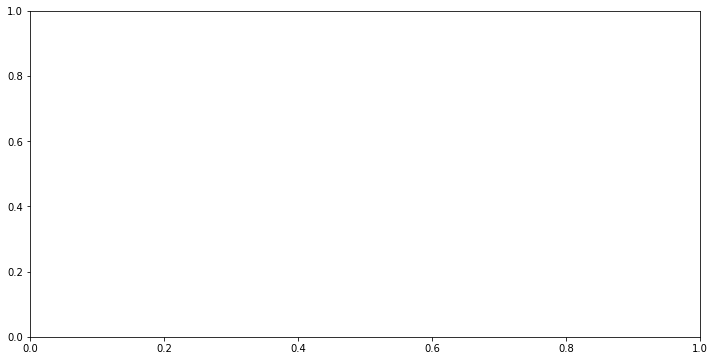

In [53]:
f, ax = plt.subplots(figsize=(12, 6))

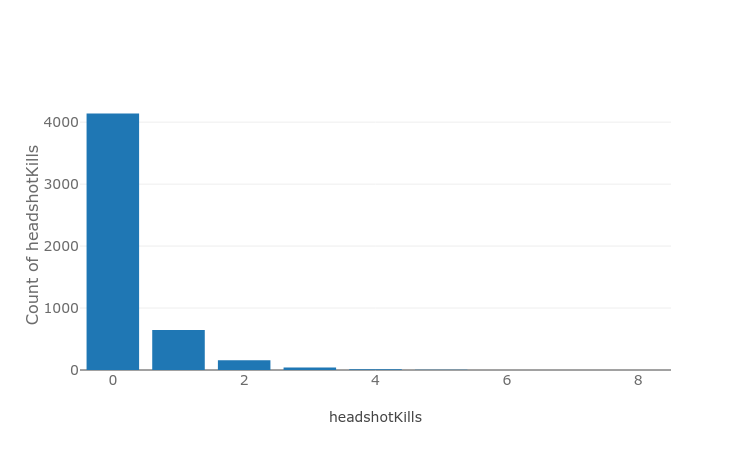

In [66]:
temp = df['headshotKills'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='headshotKills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of headshotKills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)